In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=23, labelsize=20)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from scipy.special import expit
from scipy import interpolate
from scipy import integrate
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('default')

import src.visualization as viz
import src.simulation as sim

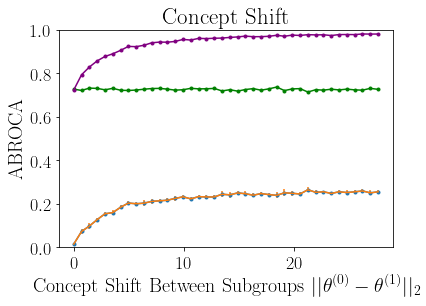

In [33]:
import plotly.express as px
from scipy.stats import sem

from src.abroca import compute_abroca, abroca_from_predictions
from src.simulation import simulate, SimulationParams


def regress(X, y, n, p_0):
    """Performs an unregularized logistic regression using given data and labels to find ABROCA and other related statistics.

    Args:
        X (np.ndarray): Data of shape (NxM) where N equals population size and M equals number of covariates.
        y (np.ndarray): Binary labels (coresponding to 'X') of shape (Nx1) where N equals population size.
        n (int): Population size.
        p_0 (float): Size of subgroup 0 as proportion of population size.

    Returns:
        If possible to calculate all statistics, returns tuple (fpr_0, tpr_0, fpr_1, tpr_1, g0auc, g1auc, abroca), where 'fpr_0' is regressor false positive rate for subgroup 0, 'tpr_0' is regressor true positive rate for subgroup 0, 'fpr_1' is regressor false positive rate for subgroup 1, 'tpr_1' is regressor true positive rate for subgroup 1, 'g0auc' is regressor AUC for subgroup 0, 'g1auc' is regressor AUC for subgroup 1, and 'abroca' is ABROCA value for the two subgroups. If not possible, returns None.
    """
    n_0 = int(round(n * p_0))
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)

    if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
        return

    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)

    if len(set(y_train)) == 1:
        return

    # regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
    regressor = LogisticRegression(solver='lbfgs')
    # regressor = LogisticRegressionCV(cv=5)
    perm = np.random.permutation(len(y_train))
    regressor.fit(X_train[perm], y_train[perm])

    return regressor, X_test_0, X_test_1, y_test_0, y_test_1


def evaluate(regressor, X_test_0, X_test_1, y_test_0, y_test_1):
    if len(set(y_test_0)) == 1 or len(set(y_test_1)) == 1:
        return

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)

    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)

    g0auc = auc(fpr_0, tpr_0)
    g1auc = auc(fpr_1, tpr_1)
    abroca = compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1)

    return fpr_0, tpr_0, fpr_1, tpr_1, g0auc, g1auc, abroca


def ABROCAvs_plot_new(plot_type, versus, r=10, s=0, both=False, **kwargs):
    print("hello")
    """Generates mean ABROCA values and standard errors that are necessary for creating 'ABROCA vs Change in Simulation Parameter' plots.

    Args:
        plot_type (str): Chooses which simulation parameter to manipulate. Options are 'n', 'p_0', 'mu_orthogonal', 'mu_parallel', 'obs_noise', 'theta_diff'.
        versus (np.ndarray[float]): Varied values of some simulation parameter which is used in calculation of ABROCA.
        r (int): Number of trials of ABROCA calculation, each with a new randomly simulated dataset based on same simulation parameters.
        s (int): Random seed.
        **kwargs: Passed to SimulationParams.

    Returns:
        A tuple (avg_abrocas, errors), where 'avg_abrocas' is an array of values for each set of simulation parameters, with each value being the mean ABROCA score over 'r' trials, and 'errors' is a similar array, but with standard errors instead of means.
    """

    np.random.seed(s)
    avg_abrocas = None

    for i in range(r):
        abrocas = [np.nan for _ in range(len(versus))]
        dflts = SimulationParams()
        X_train, y_train = simulate(dflts)
        reg = regress(X_train, y_train, dflts.n, dflts.p_0)
        if reg is None:
            continue

        for j, e in enumerate(versus):
            if plot_type == 'p_0':
                kwargs['p_0'] = e
            elif plot_type == 'mu_orthogonal':
                kwargs['mu_change'], kwargs['orthog_to_boundary'] = e, True
            elif plot_type == 'mu_parallel':
                kwargs['mu_change'] = e
            elif plot_type == 'obs_noise':
                kwargs['eta_sd'] = [.1, e]
            elif plot_type == 'theta_diff':
                if both:
                    kwargs['theta_1'] = [1 * e, 1 * e]
                else:
                    kwargs['theta_1'] = [1, 1 * e]
            elif plot_type == 'n':
                kwargs['n'] = e

            dflts_shifted = SimulationParams(**kwargs)
            X, y = simulate(dflts_shifted)
            n_0 = int(round(dflts_shifted.n * dflts_shifted.p_0))
            _, X_test_0, _, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
            _, X_test_1, _, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)

            stats = evaluate(reg[0], X_test_0, X_test_1, y_test_0, y_test_1)
            if stats is None:
                continue

            abrocas[j] = stats[6]
            
        if avg_abrocas is None:
            avg_abrocas = np.array(abrocas).reshape((-1, 1))
        else:
            avg_abrocas = np.append(avg_abrocas, np.array(abrocas).reshape((-1, 1)), axis=1)

    errors = sem(avg_abrocas, axis=1, nan_policy='omit').reshape(-1)
    avg_abrocas = np.nanmean(avg_abrocas, axis=1).ravel()

    return avg_abrocas, errors


def ABROCAvs_plot(plot_type, versus, r=10, s=0, both=False, **kwargs):
    """Generates mean ABROCA values and standard errors that are necessary for creating 'ABROCA vs Change in Simulation Parameter' plots.

    Args:
        plot_type (str): Chooses which simulation parameter to manipulate. Options are 'n', 'p_0', 'mu_orthogonal', 'mu_parallel', 'obs_noise', 'theta_diff'.
        versus (np.ndarray[float]): Varied values of some simulation parameter which is used in calculation of ABROCA.
        r (int): Number of trials of ABROCA calculation, each with a new randomly simulated dataset based on same simulation parameters.
        s (int): Random seed.
        **kwargs: Passed to SimulationParams.

    Returns:
        A tuple (avg_abrocas, errors), where 'avg_abrocas' is an array of values for each set of simulation parameters, with each value being the mean ABROCA score over 'r' trials, and 'errors' is a similar array, but with standard errors instead of means.
    """

    np.random.seed(s)
    avg_abrocas = None
    avg_g0_aucs = None
    avg_g1_aucs = None

    for i in range(r):
        abrocas = [np.nan for _ in range(len(versus))]
        g0_aucs = [np.nan for _ in range(len(versus))]
        g1_aucs = [np.nan for _ in range(len(versus))]
        for j, e in enumerate(versus):
            if plot_type == 'p_0':
                kwargs['p_0'] = e
            elif plot_type == 'mu_orthogonal':
                kwargs['mu_change'], kwargs['orthog_to_boundary'] = e, True
            elif plot_type == 'mu_parallel':
                kwargs['mu_change'] = e
            elif plot_type == 'obs_noise':
                kwargs['eta_sd'] = [.1, e]
            elif plot_type == 'theta_diff':
                if both:
                    kwargs['theta_1'] = [1 * e * 20 - 4, 1 * e * 20 - 4]
                else:
#                     kwargs['theta_1'] = [1, 1 * e * 20 - 4]
                    kwargs['theta_1'] = [(2**0.5)*np.cos(e*np.pi), (2**0.5)*np.sin(e*np.pi)]
                    
            elif plot_type == 'n':
                kwargs['n'] = e

            dflts = SimulationParams(**kwargs)
            X_train, y_train = simulate(dflts) # cell acts like old code if X_train, y_train = simulate(dflts), new code if X_train, y_train = simulate()
            X, y = simulate(dflts)
            
            reg_train = regress(X_train, y_train, dflts.n, dflts.p_0)
            reg = regress(X, y, dflts.n, dflts.p_0)
            if reg is None:
                continue
            
            stats = evaluate(reg_train[0], reg[1], reg[2], reg[3], reg[4])
            
            abrocas[j] = stats[6]
            g0_aucs[j] = stats[4]
            g1_aucs[j] = stats[5]
            
        if avg_abrocas is None:
            avg_abrocas = np.array(abrocas).reshape((-1, 1))
        else:
            avg_abrocas = np.append(avg_abrocas, np.array(abrocas).reshape((-1, 1)), axis=1)
        
        if avg_g0_aucs is None:
            avg_g0_aucs = np.array(g0_aucs).reshape((-1, 1))
        else:
            avg_g0_aucs = np.append(avg_g0_aucs, np.array(g0_aucs).reshape((-1, 1)), axis=1)
        
        if avg_g1_aucs is None:
            avg_g1_aucs = np.array(g1_aucs).reshape((-1, 1))
        else:
            avg_g1_aucs = np.append(avg_g1_aucs, np.array(g1_aucs).reshape((-1, 1)), axis=1)

    errors = sem(avg_abrocas, axis=1, nan_policy='omit').reshape(-1)
    avg_abrocas = np.nanmean(avg_abrocas, axis=1).ravel()
    
    avg_g0_aucs = np.nanmean(avg_g0_aucs, axis=1).ravel()
    avg_g1_aucs = np.nanmean(avg_g1_aucs, axis=1).ravel()

    return avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs


# theta difference vs. ABROCA plot example
theta_scale = np.arange(.25,1.25,0.025)
n = 10000
r = 10
s = 7
both = True

avg_abrocas, errors, avg_g0_aucs, avg_g1_aucs = ABROCAvs_plot('theta_diff', theta_scale, s=s, n=n, r=r, both=both)

if both:
    theta_diff = [np.linalg.norm(np.array([[1*e*20-4,1*e*20-4]]) - np.array([[1,1]]), ord=2) for e in theta_scale]
else:
    theta_diff = [np.linalg.norm(np.array([[(2**0.5)*np.cos(e*np.pi), (2**0.5)*np.sin(e*np.pi)]]) - np.array([[1,1]]), ord=2) for e in theta_scale]
#     theta_diff = [np.linalg.norm(np.array([[1,1*e*20-4]]) - np.array([[1,1]]), ord=2) for e in theta_scale]
    
plt.xscale('linear')
plt.yscale('linear')
plt.plot(theta_diff, avg_abrocas, marker='.')
plt.errorbar(theta_diff, avg_abrocas, yerr=2*errors)
plt.plot(theta_diff, avg_g0_aucs, marker='.', color='green')
plt.plot(theta_diff, avg_g1_aucs, marker='.', color='purple')
plt.xlabel(r'Concept Shift Between Subgroups $||\theta^{(0)} - \theta^{(1)} ||_2$')
plt.ylabel('ABROCA')
plt.ylim([0,1])
plt.title('Concept Shift')
plt.savefig(f'figures/ConceptShift(n={n},r={r},s={s}).pdf', bbox_inches="tight")
plt.show()

/Users/nswinger/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


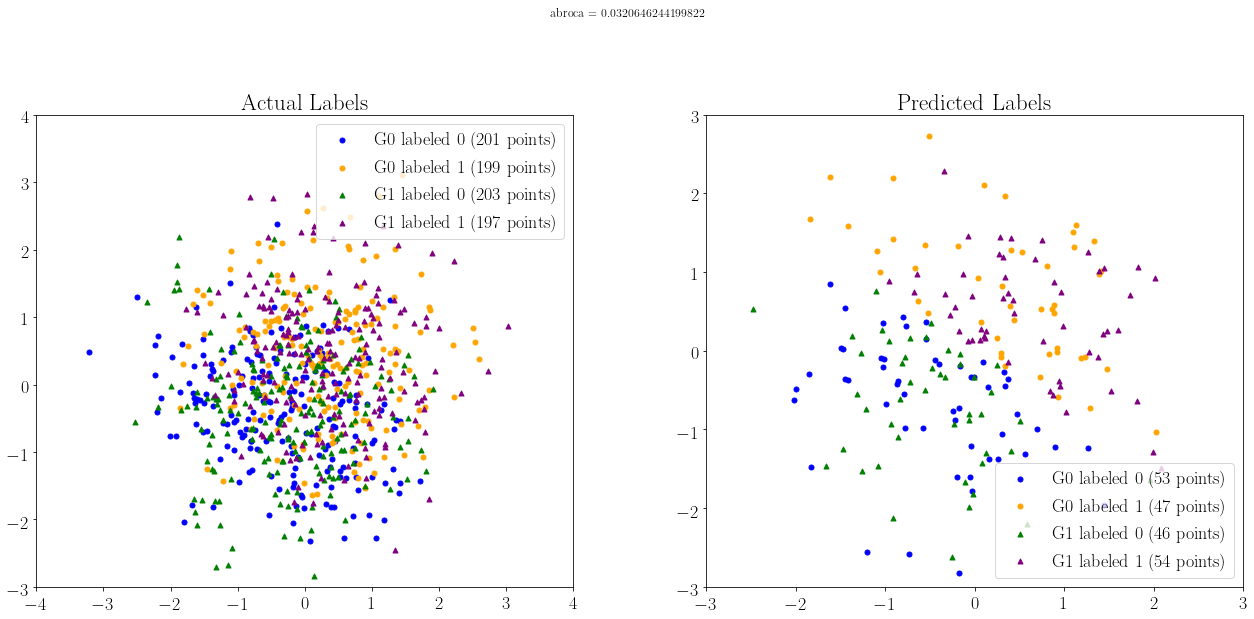

In [83]:
def visualize_data(point_size=.5, s=0, figsize=(20, 10), **kwargs):
    """Generates either 1 or 2 figures to help display simulated data as a scatter plot.

    Args:
        point_size (float): Size of scatter plot points, passed as argument to plt.scatter.
        s (int): Random seed.
        figsize (tuple[int]): Size of matplotlib.pyplot figure.
        **kwargs: Passed to SimulationParams

    Returns:
        If data is generated with 2 covariates, returns a matplotlib.pyplot figure with 2 scatter plots (group 0 and 1 data), and 2 ROC plots (group 0 and group 1). If more than 2 covariates, returns the tuple returned by visualize_data_3d.
    """
    np.random.seed(s)
    
    dflts = SimulationParams(**kwargs)
    dflts1 = SimulationParams(n=kwargs['n'])
    X_t, y_t = simulate(dflts1) # cell acts like old code if X_train, y_train = simulate(dflts), new code if X_train, y_train = simulate(dflts1)
    X, y = simulate(dflts)
            
    n_0 = int(round(dflts.n * dflts.p_0))
    _, X_test_0, _, y_test_0 = train_test_split(X[:n_0], y[:n_0], test_size=0.2, random_state=0)
    _, X_test_1, _, y_test_1 = train_test_split(X[n_0:], y[n_0:], test_size=0.2, random_state=0)
    
    X_train_0, _, y_train_0, _ = train_test_split(X_t[:n_0], y_t[:n_0], test_size=0.2, random_state=0)
    X_train_1, _, y_train_1, _ = train_test_split(X_t[n_0:], y_t[n_0:], test_size=0.2, random_state=0)

    plot_x0_0 = [a for a, b in zip(X_train_0[:, 0], y_train_0) if b == 0]
    plot_y0_0 = [a for a, b in zip(X_train_0[:, 1], y_train_0) if b == 0]
    plot_x0_1 = [a for a, b in zip(X_train_0[:, 0], y_train_0) if b == 1]
    plot_y0_1 = [a for a, b in zip(X_train_0[:, 1], y_train_0) if b == 1]
    plot_x1_0 = [a for a, b in zip(X_train_1[:, 0], y_train_1) if b == 0]
    plot_y1_0 = [a for a, b in zip(X_train_1[:, 1], y_train_1) if b == 0]
    plot_x1_1 = [a for a, b in zip(X_train_1[:, 0], y_train_1) if b == 1]
    plot_y1_1 = [a for a, b in zip(X_train_1[:, 1], y_train_1) if b == 1]

    X_train = np.append(X_train_0, X_train_1, axis=0)
    y_train = np.append(y_train_0, y_train_1, axis=0)

    perm = np.random.permutation(len(y_train))

    regressor = LogisticRegressionCV(cv=5)
    regressor.fit(X_train[perm], y_train[perm])

    y_pred_0 = regressor.predict(X_test_0)
    y_pred_1 = regressor.predict(X_test_1)
    
    plot_x0_0_test = [a for a, b in zip(X_test_0[:, 0], y_pred_0) if b == 0]
    plot_y0_0_test = [a for a, b in zip(X_test_0[:, 1], y_pred_0) if b == 0]
    plot_x0_1_test = [a for a, b in zip(X_test_0[:, 0], y_pred_0) if b == 1]
    plot_y0_1_test = [a for a, b in zip(X_test_0[:, 1], y_pred_0) if b == 1]
    plot_x1_0_test = [a for a, b in zip(X_test_1[:, 0], y_pred_1) if b == 0]
    plot_y1_0_test = [a for a, b in zip(X_test_1[:, 1], y_pred_1) if b == 0]
    plot_x1_1_test = [a for a, b in zip(X_test_1[:, 0], y_pred_1) if b == 1]
    plot_y1_1_test = [a for a, b in zip(X_test_1[:, 1], y_pred_1) if b == 1]


    fpr_0, tpr_0, _ = roc_curve(y_test_0, y_pred_0)
    fpr_1, tpr_1, _ = roc_curve(y_test_1, y_pred_1)
    g0auc = auc(fpr_0, tpr_0)
    g1auc = auc(fpr_1, tpr_1)
    abroca = compute_abroca(fpr_0, tpr_0, fpr_1, tpr_1)

    fig, axs = plt.subplots(1, 2, figsize=figsize)
        
    axs[0].scatter(plot_x0_0, plot_y0_0, color='blue', s=point_size, label=f'G0 labeled 0 ({len(plot_x0_0)} points)', marker='o')
    axs[0].scatter(plot_x0_1, plot_y0_1, color='orange', s=point_size,
                      label=f'G0 labeled 1 ({len(plot_x0_1)} points)', marker='o')
    axs[0].scatter(plot_x1_0, plot_y1_0, color='green', s=point_size, label=f'G1 labeled 0 ({len(plot_x1_0)} points)', marker='^')
    axs[0].scatter(plot_x1_1, plot_y1_1, color='purple', s=point_size,
                      label=f'G1 labeled 1 ({len(plot_x1_1)} points)', marker='^')
    axs[0].legend()
    axs[0].set_title('Actual Labels')

    axs[1].scatter(plot_x0_0_test, plot_y0_0_test, color='blue', s=point_size, label=f'G0 labeled 0 ({len(plot_x0_0_test)} points)', marker='o')
    axs[1].scatter(plot_x0_1_test, plot_y0_1_test, color='orange', s=point_size,
                      label=f'G0 labeled 1 ({len(plot_x0_1_test)} points)', marker='o')
    axs[1].scatter(plot_x1_0_test, plot_y1_0_test, color='green', s=point_size, label=f'G1 labeled 0 ({len(plot_x1_0_test)} points)', marker='^')
    axs[1].scatter(plot_x1_1_test, plot_y1_1_test, color='purple', s=point_size,
                      label=f'G1 labeled 1 ({len(plot_x1_1_test)} points)', marker='^')
    axs[1].legend()
    axs[1].set_title('Predicted Labels')

    xlim = [int(min(plot_x0_0 + plot_x0_1 + plot_x1_0 + plot_x1_1)) - 1,
            int(max(plot_x0_0 + plot_x0_1 + plot_x1_0 + plot_x1_1)) + 1]
    ylim = [int(min(plot_y0_0 + plot_y0_1 + plot_y1_0 + plot_y1_1)) - 1,
            int(max(plot_y0_0 + plot_y0_1 + plot_y1_0 + plot_y1_1)) + 1]
    
    xlim_test = [int(min(plot_x0_0_test + plot_x0_1_test + plot_x1_0_test + plot_x1_1_test)) - 1,
            int(max(plot_x0_0_test + plot_x0_1_test + plot_x1_0_test + plot_x1_1_test)) + 1]
    ylim_test = [int(min(plot_y0_0_test + plot_y0_1_test + plot_y1_0_test + plot_y1_1_test)) - 1,
            int(max(plot_y0_0_test + plot_y0_1_test + plot_y1_0_test + plot_y1_1_test)) + 1]
    
    axs[0].set_xlim(xlim)
    axs[1].set_xlim(xlim_test)
    axs[0].set_ylim(ylim)
    axs[1].set_ylim(ylim_test)

    fig.suptitle(f'abroca = {abroca}')
    fig.tight_layout(pad=10.0)

    return fig

e=.25
fig = visualize_data(point_size=25, s=13, n=1000, theta_1=[(2**0.5)*np.cos(e*np.pi), (2**0.5)*np.sin(e*np.pi)])
fig.show()
